In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sudarsan27_sentimental_analysis_movie_review_path = kagglehub.dataset_download('sudarsan27/sentimental-analysis-movie-review')

print('Data source import complete.')


Columns: Index(['Comments', 'Ratings'], dtype='object')
                                            Comments  Ratings
0  I didnt go in with big hopes, but i was expect...        8
1  A unique genre, a well written story (script) ...        8
2  Majestic at scale, grandeur in VFX, and great ...        9
3  "Kalki 2898" is not just a movie; it's an expe...       10
4  Best Indian movie Nagi combined Hindu mytholog...       10
Shape of X_train_pad: (4000, 200)
Shape of X_test_pad: (1000, 200)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,733 (5.07 MB)

 Trainable params: 1,329,733 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5615 - loss: 1.1708 - val_accuracy: 0.7110 - val_loss: 0.6737
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.6749 - loss: 0.6965 - val_accuracy: 0.8370 - val_loss: 0.4554
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.8153 - loss: 0.5128 - val_accuracy: 0.8370 - val_loss: 0.4040
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8490 - loss: 0.3838 - val_accuracy: 0.8370 - val_loss: 0.3954
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.8348 - loss: 0.4215 - val_accuracy: 0.8370 - val_loss: 0.3944
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        48
     Class 1       0.00      0.00      0.00        40
     Class 2       1.00      0.50      0.67       170
     Class 3       0.91      1.00      0.95       387
     Class 4       0

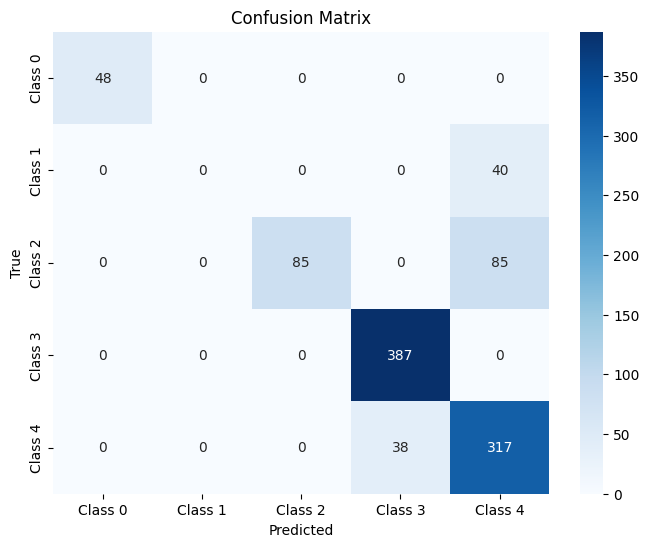

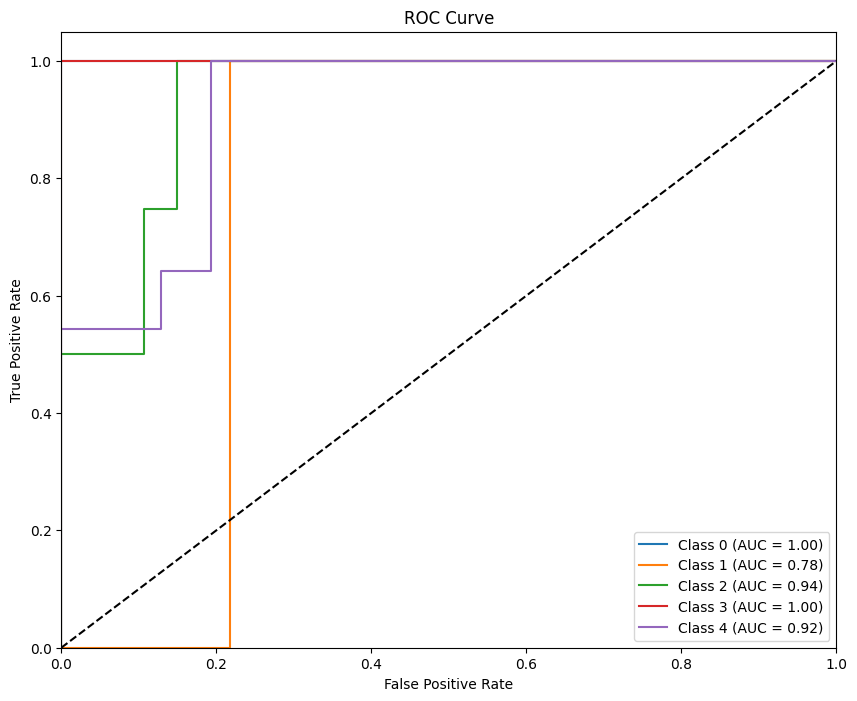

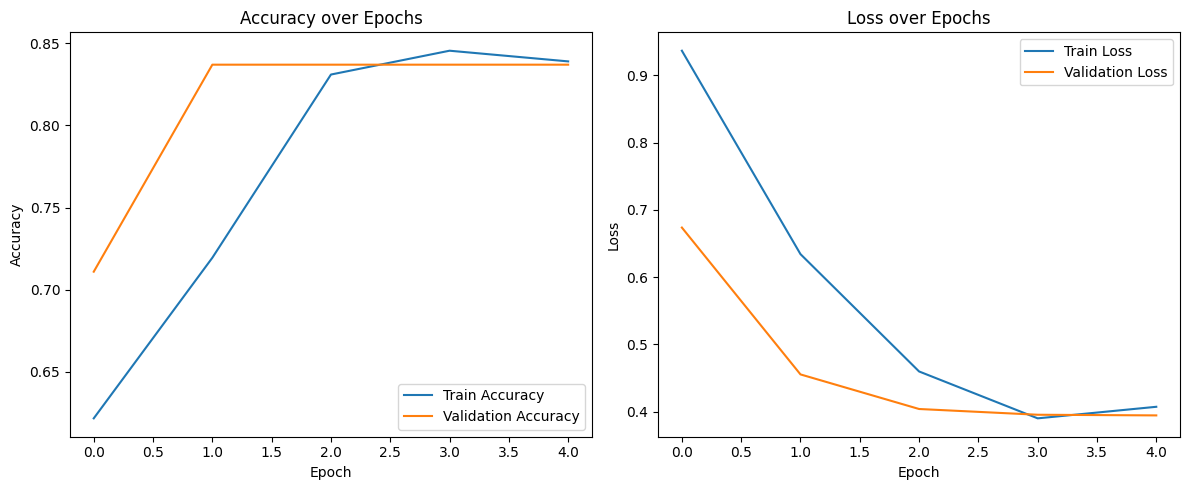

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("/kaggle/input/sentimental-analysis-movie-review/kalki_movie_reviews.csv", encoding='latin-1')
print("Columns:", df.columns)
print(df.head())

# Update with the actual column names
TEXT_COLUMN = 'Comments'
LABEL_COLUMN = 'Ratings'

# Preprocessing
X = df[TEXT_COLUMN].astype(str)
y = df[LABEL_COLUMN]

# Encode labels into categories
y_encoded = pd.cut(y, bins=[0, 3, 5, 7, 9, 10], labels=[0, 1, 2, 3, 4])
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Check shapes
print(f"Shape of X_train_pad: {X_train_pad.shape}")
print(f"Shape of X_test_pad: {X_test_pad.shape}")

# Define LSTM parameters
embedding_dim = 128
lstm_units = 64

# Define the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim),
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation='softmax')
])

# Build and compile model
model.build(input_shape=(None, max_len))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
epochs = 5
batch_size = 32
history = model.fit(
    X_train_pad, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_pad, y_test)
)

# Evaluation
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)], zero_division=0))

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (multi-class)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy & Loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
